# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [354]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [355]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
    
def safe_find_all_stars(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return len(f_child.find_next_sibling().find_all('span', class_ = 'star fill')) if f_child else pd.NA

def safe_find_next_sibling(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return f_child.find_next_sibling().get_text() if f_child else pd.NA


columns = ['name', 'header', 'time', 'text_reviow', 'Aircraft', 'Traveller', 'Seat_Type', 'Route',
           'Date_Flown', 'star_reting_aircraft', 'star_reting_Food', 'star_reting_Inflight', 'star_reting_Ground_Service',
           'star_reting_Wifi', 'star_reting_Value_For_Money', 'recommended']

review_ration_catagory = ['review-rating-header aircraft', 'review-rating-header type_of_traveller', 'review-rating-header cabin_flown', 
'review-rating-header route', 'review-rating-header date_flown']
review_ration_stars = ['review-rating-header cabin_staff_service', 'review-rating-header food_and_beverages', 
'review-rating-header inflight_entertainment', 'review-rating-header ground_service', 'review-rating-header wifi_and_connectivity', 
'review-rating-header value_for_money']

reviews = pd.DataFrame(columns= columns)
pages = 10
page_size = 100

In [356]:
for i in range(1, pages + 1):
    
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    bodys = parsed_content.find_all("div", {"class": "body"})
    for i, body in enumerate(bodys):
        row = []
        row.append(body.find('span', itemprop = 'name').get_text())
        row.append(body.find('h2', class_ = 'text_header').get_text().replace('"',''))
        row.append(body.find('time', itemprop = 'datePublished').get('datetime'))
        row.append(body.find('div', class_ = 'text_content').get_text())
        
        for j in review_ration_catagory:
            row.append(safe_find_next_sibling(body, j))

        for j in review_ration_stars:
            row.append(safe_find_all_stars(body, j))
        
        row.append(body.find('td', class_ = 'review-rating-header recommended').find_next_sibling('td').get_text())
        
        reviews.loc[len(reviews)] = row # type: ignore

Scraping page 1


Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10


In [357]:
reviews.head(1)

,name,header,time,text_reviow,Aircraft,Traveller,Seat_Type,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,S Marakides,ravioli pasta had dried out,2023-08-24,✅ Trip Verified | Ground and cabin crew alway...,A320neo,Solo Leisure,Business Class,Larnaca to London Heathrow,July 2023,3,1,<NA>,3,NaN,1,yes


#### Deviding Route in to two columns "From" and "To"

In [358]:
split_route = reviews['Route'].str.split(' to ', expand=True)
reviews.insert(7, 'From', split_route[0])
reviews.insert(8, 'To', split_route[1])

#### Making new column for if the tripe is Verified

In [359]:
def extract_verification(text):
    if '✅ Trip Verified | ' in text:
        return 1, text.replace('✅ Trip Verified | ', '')
    elif 'Not Verified | ' in text:
        return 0, text.replace('Not Verified | ', '')
    else:
        return None, text

reviews.insert(3, 'Verified', reviews['text_reviow'].apply(lambda x: extract_verification(x)[0]))
reviews['text_reviow'] = reviews['text_reviow'].apply(lambda x: extract_verification(x)[1])

In [360]:
reviews['recommended'] = reviews['recommended'].replace({'yes': 1, 'no': 0})

#### Foremating date flown

In [361]:
reviews['Date_Flown'] = pd.to_datetime(reviews['Date_Flown'], format='%B %Y')

In [362]:
reviews.head()

,name,header,time,Verified,text_reviow,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,S Marakides,ravioli pasta had dried out,2023-08-24,1.0,Ground and cabin crew always provide good cus...,A320neo,Solo Leisure,Business Class,Larnaca,London Heathrow,Larnaca to London Heathrow,2023-07-01,3,1,<NA>,3,NaN,1,1
1,S Brydon,Great customer service,2023-08-19,1.0,My family flew from Washington to London on a...,A380,Family Leisure,Economy Class,Washington,London,Washington to London,2023-08-01,5,3,2,1,NaN,4,1
2,E Smyth,Cabin crew were all fantastic,2023-08-13,1.0,Easy check in a T5. Galleries south and North...,A380,Family Leisure,Business Class,London,Miami,London to Miami,2023-08-01,5,5,5,4,5,4,1
3,D Daly,asked us to check our bags,2023-08-12,0.0,"Flight delayed by an hour, it happens, no big...",NaN,Family Leisure,Economy Class,London,Paris,London to Paris,2023-08-01,1,<NA>,NaN,1,NaN,1,0
4,Karima Saci,service is extremely poor,2023-08-11,0.0,The staff are very rude and not trained proper...,NaN,Family Leisure,Economy Class,London,Algiers,London to Algiers,2023-08-01,1,1,1,1,1,1,0


In [363]:
stars_columns = ['star_reting_aircraft',	'star_reting_Food', 'star_reting_Inflight',	'star_reting_Ground_Service',	'star_reting_Wifi',	'star_reting_Value_For_Money']
def fill_nan_with_row_mean(row):
    return row.fillna(row.mean())

# Apply the function to each row
reviews[stars_columns] = reviews[stars_columns].apply(fill_nan_with_row_mean, axis=1)

### Chacking noumbers of route present in the data

In [364]:
reviews['Route'].nunique()

651

Note: found 93 out of 100 so the mostly all the Route is unique

#### Checking if the there is any difference in rating between verified tripe or not verified tripe

In [365]:
print('Total Number of recomending and not recomending')
print(reviews.recommended.value_counts())

print('\nTotal Number of recomending and not recomending only verified tripe')
print(reviews.loc[reviews['Verified']==1, 'recommended'].value_counts())

print('\nTotal Number of recomending and not recomending by not verified tripe')
print(reviews.loc[reviews['Verified']==0, 'recommended'].value_counts())

# reviews.groupby('recommended')[stars_columns].mean()

Total Number of recomending and not recomending
recommended
0    655
1    345
Name: count, dtype: int64

Total Number of recomending and not recomending only verified tripe
recommended
0    505
1    289
Name: count, dtype: int64

Total Number of recomending and not recomending by not verified tripe
recommended
0    148
1     53
Name: count, dtype: int64


In [366]:
mean_of_stars_verified = reviews.loc[reviews['Verified']==1, stars_columns].mean()
mean_of_stars_not_verified = reviews.loc[reviews['Verified']==0, stars_columns].mean()
mean_of_stars = reviews.loc[:, stars_columns].mean()



print('------------ Verified mean of stars ------------\n',
    mean_of_stars_verified, 
    '\n------------ Non-verified mean of stars ------------\n',
    mean_of_stars_not_verified, 
    '\n------------ Over all mean of stars ------------\n',
    mean_of_stars)


------------ Verified mean of stars ------------
 star_reting_aircraft           3.035894
star_reting_Food               2.517695
star_reting_Inflight           2.591751
star_reting_Ground_Service     2.651134
star_reting_Wifi               2.525567
star_reting_Value_For_Money    2.486146
dtype: float64 
------------ Non-verified mean of stars ------------
 star_reting_aircraft           2.985075
star_reting_Food               2.411277
star_reting_Inflight           2.487645
star_reting_Ground_Service     2.363184
star_reting_Wifi               2.292620
star_reting_Value_For_Money    2.263682
dtype: float64 
------------ Over all mean of stars ------------
 star_reting_aircraft           3.030500
star_reting_Food               2.502717
star_reting_Inflight           2.574867
star_reting_Ground_Service     2.595000
star_reting_Wifi               2.479117
star_reting_Value_For_Money    2.446000
dtype: float64


- There batter review from the people not verified then people are, also over all the reviews are avarige.
- My main speculation is to deside if a review is good or bad we can use if Airways is recommended or not.

In [367]:
reviews['Date_Flown'].nunique()

65

In [368]:
reviews.head()

,name,header,time,Verified,text_reviow,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,S Marakides,ravioli pasta had dried out,2023-08-24,1.0,Ground and cabin crew always provide good cus...,A320neo,Solo Leisure,Business Class,Larnaca,London Heathrow,Larnaca to London Heathrow,2023-07-01,3.0,1.0,2.0,3.0,2.0,1.0,1
1,S Brydon,Great customer service,2023-08-19,1.0,My family flew from Washington to London on a...,A380,Family Leisure,Economy Class,Washington,London,Washington to London,2023-08-01,5.0,3.0,2.0,1.0,3.0,4.0,1
2,E Smyth,Cabin crew were all fantastic,2023-08-13,1.0,Easy check in a T5. Galleries south and North...,A380,Family Leisure,Business Class,London,Miami,London to Miami,2023-08-01,5.0,5.0,5.0,4.0,5.0,4.0,1
3,D Daly,asked us to check our bags,2023-08-12,0.0,"Flight delayed by an hour, it happens, no big...",NaN,Family Leisure,Economy Class,London,Paris,London to Paris,2023-08-01,1.0,1.0,1.0,1.0,1.0,1.0,0
4,Karima Saci,service is extremely poor,2023-08-11,0.0,The staff are very rude and not trained proper...,NaN,Family Leisure,Economy Class,London,Algiers,London to Algiers,2023-08-01,1.0,1.0,1.0,1.0,1.0,1.0,0


In [369]:
mean_reviews_on_date_flown = reviews.groupby('Date_Flown')['recommended'].mean()
mean_stars_on_date_flown = reviews.groupby('Date_Flown')[stars_columns].mean()
mean_stars_on_date_flown

,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money
Date_Flown,,,,,,
2018-02-01,5.000000,4.000000,4.000000,2.000000,4.000000,5.000000
2018-03-01,4.000000,3.500000,4.000000,4.500000,4.100000,4.500000
2018-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-06-01,3.500000,3.000000,3.500000,3.500000,3.000000,2.000000
2018-07-01,2.000000,1.333333,1.333333,1.000000,1.333333,1.000000
...,...,...,...,...,...,...
2023-04-01,2.636364,2.318182,2.788636,2.318182,2.106818,2.000000
2023-05-01,2.347826,2.113043,2.169565,1.739130,1.760870,1.521739
2023-06-01,2.689655,2.068966,2.181034,1.724138,1.898276,1.689655


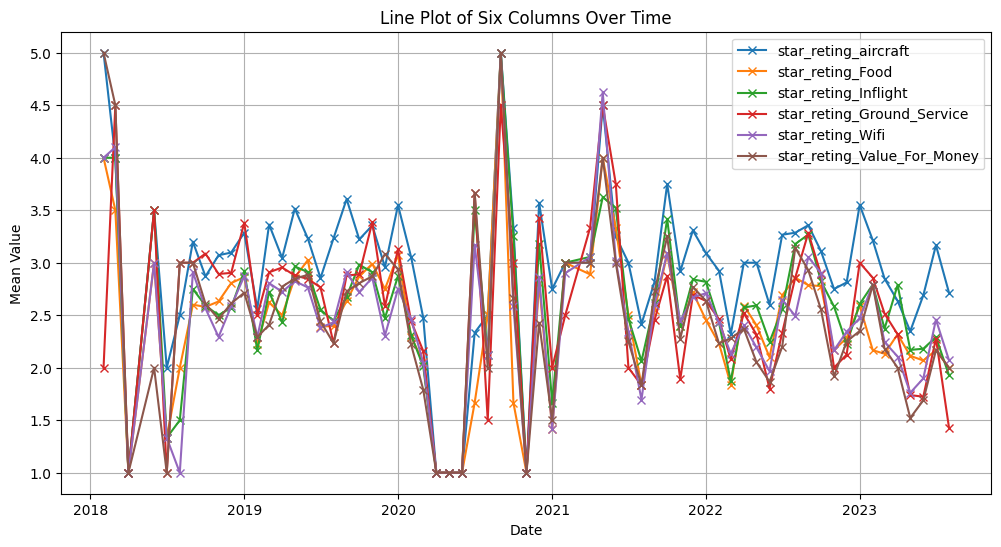

In [372]:
plt.figure(figsize=(12, 6))

for column_name in mean_stars_on_date_flown.columns:
    plt.plot(mean_stars_on_date_flown.index, mean_stars_on_date_flown[column_name], '-x', label=column_name)

plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.title('Line Plot of Six Columns Over Time')
plt.legend()
plt.grid(True)

In [371]:
reviews.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.